# Прогнозирование оттока клиента

# Содержание

[1 Загрузка данных](#1-Загрузка-данных)

[Промежуточный вывод к пункту 1](#Промежуточный-вывод-к-пункту-1)

[2 Исследовательский анализ данных (EDA)](#2-Исследовательский-анализ-данных-(EDA))

[Промежуточный вывод к пункту 2](#Промежуточный-вывод-к-пункту-2)

[3 Построение модели прогнозирования оттока клиентов](#3-Построение-модели-прогнозирования-оттока-клиентов)

[Промежуточный вывод к пункту 3](#Промежуточный-вывод-к-пункту-3)

[4 Кластеризация клиентов](#4-Кластеризация-клиентов)

[Промежуточный вывод к пункту 4](#Промежуточный-вывод-к-пункту-4)

[5 Выводы и базовые рекомендации по работе с клиентами](#5-Выводы-и-базовые-рекомендации-по-работе-с-клиентами)

# 1 Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split             # разделение на обучающую и валидационную выборки
from sklearn.preprocessing import StandardScaler                 # стандартизация данных

from sklearn.linear_model import LogisticRegression              # логистическая регрессия
from sklearn.ensemble import RandomForestClassifier              # случайный лес-классификатор

from sklearn.metrics import accuracy_score, precision_score, recall_score     # метрики классификации

from scipy.cluster.hierarchy import dendrogram, linkage          # дендрограмма
from sklearn.cluster import KMeans                               # K-Means (кластеризация)

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('gym_churn.csv')

In [3]:
df.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
2407,0,1,1,0,1,1,0,29,290.074985,1.0,0,0.348909,0.000000,1
3421,1,1,0,1,1,12,1,28,88.119477,12.0,2,1.168489,0.998206,0
781,0,1,1,1,1,6,0,25,307.159370,5.0,5,2.984467,3.168990,0
1996,0,1,1,1,1,12,1,30,104.333771,10.0,13,3.320793,3.375962,0
2037,1,1,0,0,1,1,0,29,109.468311,1.0,6,2.668372,2.818220,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
df.duplicated().sum()

0

# Промежуточный вывод к пункту 1

В таблице 14 столбцов и 4000 строк. Пропущенных данных и дубликатов нет. Используются данные типа "целое число" и "число с плавающей точкой". Можно привести часть данных к типу bool, но практической пользы от этого не будет.

# 2 Исследовательский анализ данных (EDA)

Можно изучить средние значения и стандартные отклонения.

In [6]:
df.describe()[1:3].round(2)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
mean,0.51,0.85,0.49,0.31,0.9,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.3,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44


По данным за месяц до оттока видно, что:

- среди клиентов примерно одинаковое число женщин и мужчин;

- 85 % клиентов живёт или работает в районе, где находится фитнес-центр;

- 49 % клиентов являются сотрудниками компании-партнёра клуба;

- 31 % клиентов использовал промо-код от знакомого при оплате первого абонемента;

- 90 % клиентов указали свой номер телефона;

- средняя длительность текущего действующего абонемента 4 месяца и 20 дней;

- 41 % клинетов посещал групповые занятия;

- средний возраст клиента - 29 лет;

- суммарная выручка от других услуг фитнес-центра с клиента в среднем составляет 147;

- средний срок до окончания текущего действующего абонемента 4 месяца и 10 дней;

- среднее время с момента первого обращения в фитнес-центр 3 месяца и 22 дня;

- средняя частота посещений в неделю за всё время с начала действия абонемента одного клиента в среднем составляет 1,88;

- средняя частота посещений в неделю за предыдущий месяц одного клиента в среднем составляет 1,7;

- 27 % клиентов попало в отток.

Можно изучить средние значения признаков в двух группах (тех, кто ушел в отток, и тех, кто остался).

In [7]:
df.groupby('Churn').mean().round(2)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


По сгруппированным данным видно, что:

- в обеих групппах примерно одинаковое число женщин и мужчин;

- 87 % (оставшиеся клиенты) и 77 % (отток) клиентов живёт или работает в районе, где находится фитнес-центр;

- 53 % (оставшиеся клиенты) и 36 % (отток) клиентов являются сотрудниками компании-партнёра клуба;

- 35 % (оставшиеся клиенты) и 18 % (отток) клиентов использовали промо-код от знакомого при оплате первого абонемента;

- в обеих групппах 90 % клиентов указали свой номер телефона;

- средняя длительность текущего действующего абонемента 5 месяцев и 23 дня (оставшиеся клиенты) и 1 месяц и 22 дня (отток);

- 46 % (оставшиеся клиенты) и 27 % (отток) клиентов посещали групповые занятия;

- средний возраст клиента - 30 (оставшиеся клиенты) и 27 (отток) лет;

- суммарная выручка от других услуг фитнес-центра с клиента в среднем составляет 158 (оставшиеся клиенты) и 115 (отток);

- средний срок до окончания текущего действующего абонемента 5 месяцев и 8 дней (оставшиеся клиенты) и 1 месяц 20 дней (отток);

- среднее время с момента первого обращения в фитнес-центр 4 месяца 21 день (оставшиеся клиенты) и 1 месяц (отток);

- средняя частота посещений в неделю за всё время с начала действия абонемента одного клиента в среднем составляет 2,02 (оставшиеся клиенты) и 1,47 (отток);

- средняя частота посещений в неделю за предыдущий месяц одного клиента в среднем составляет 2,03 (оставшиеся клиенты) и 1,04 (отток).

Построение столбчатых гистограмм признаков для двух групп клиентов:

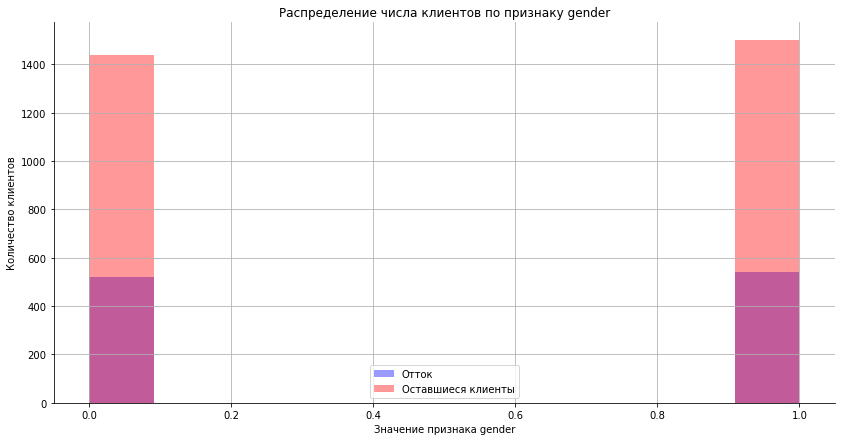

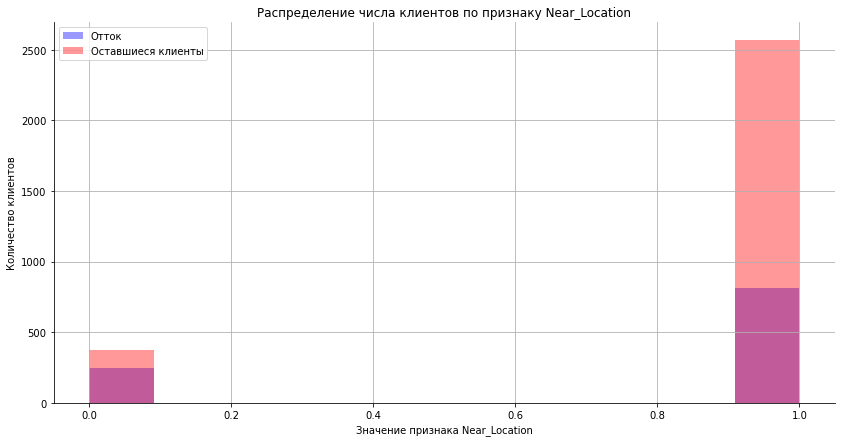

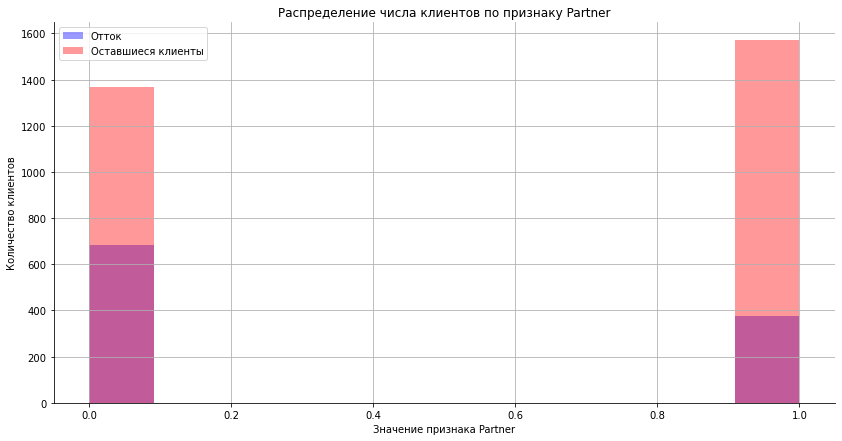

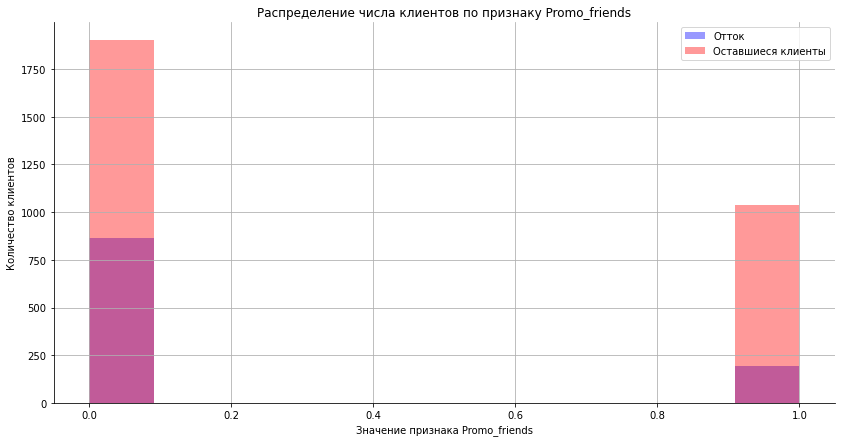

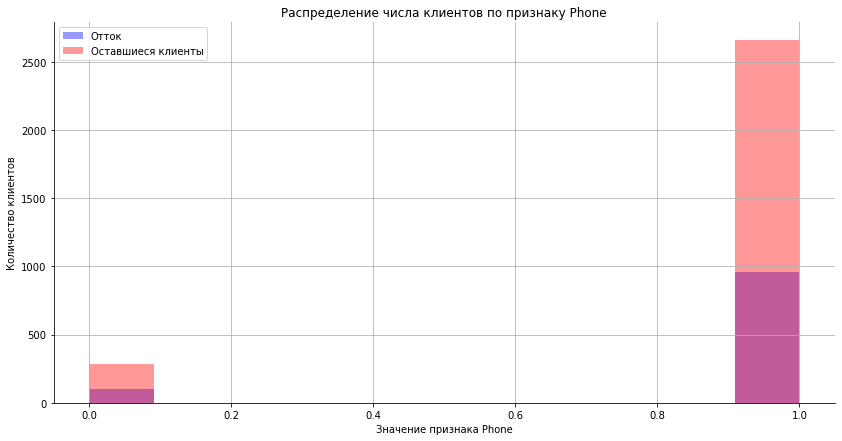

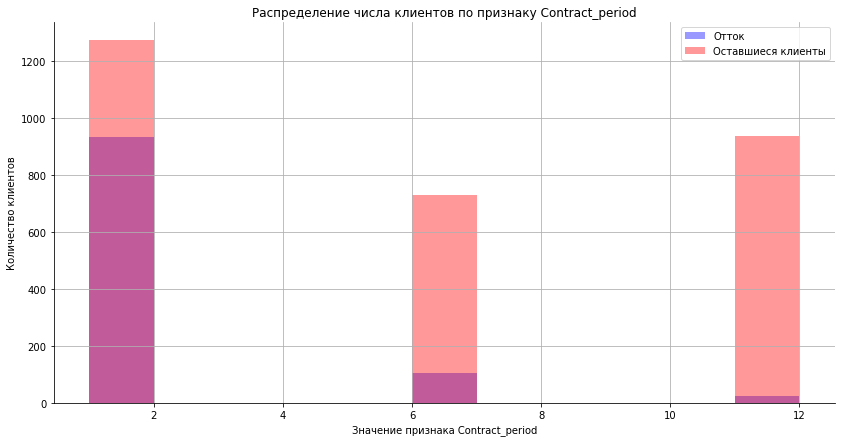

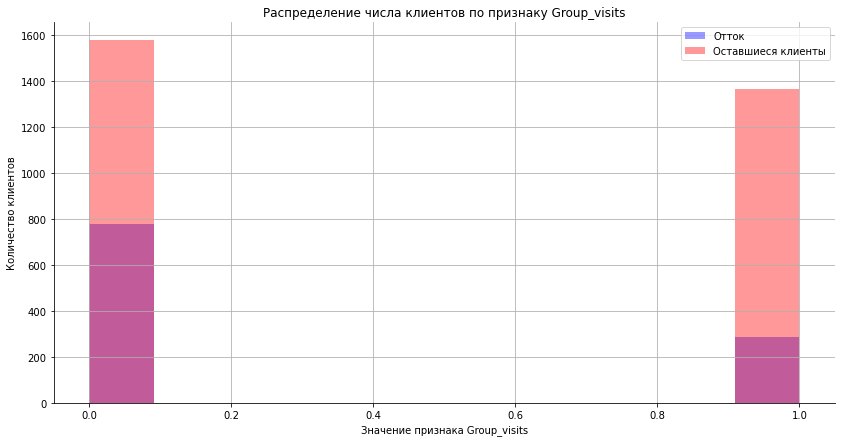

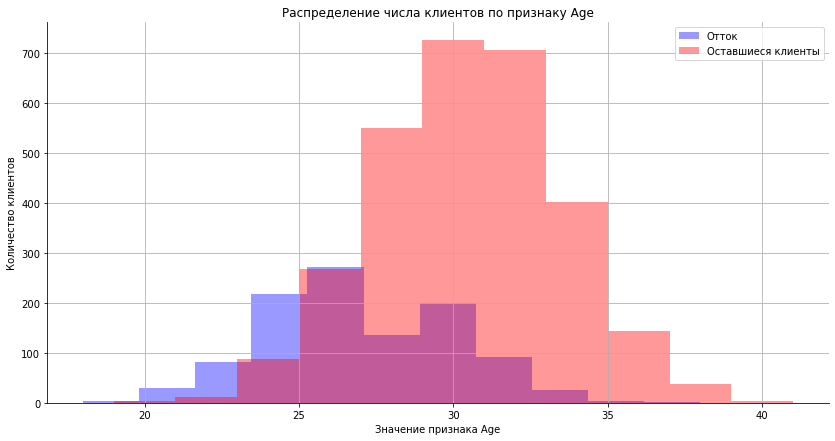

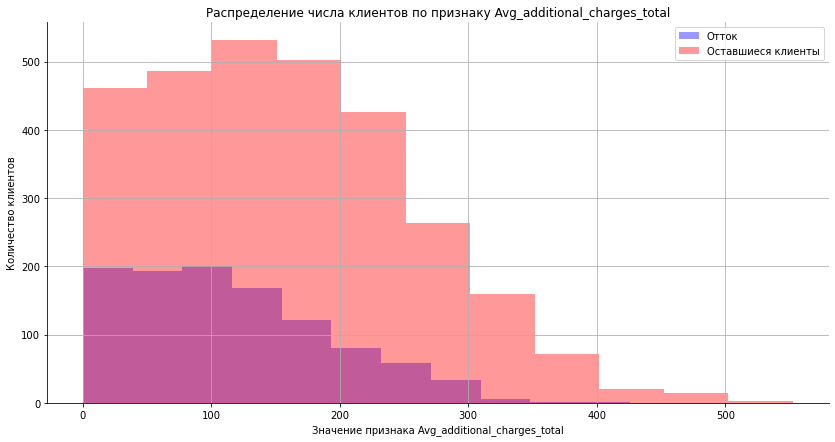

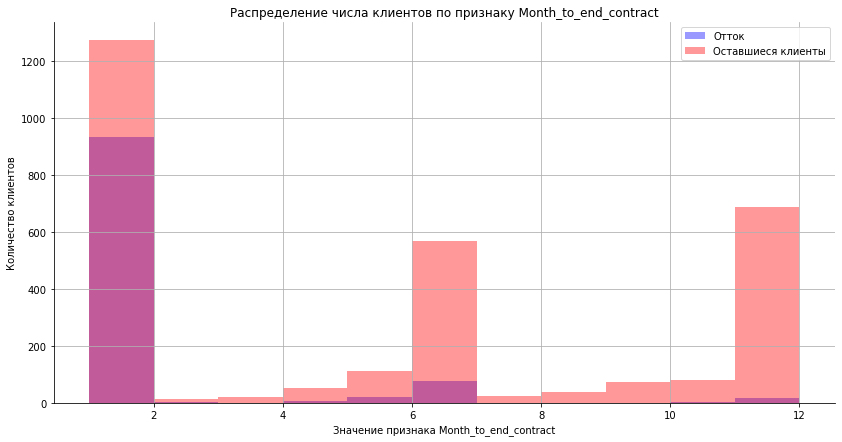

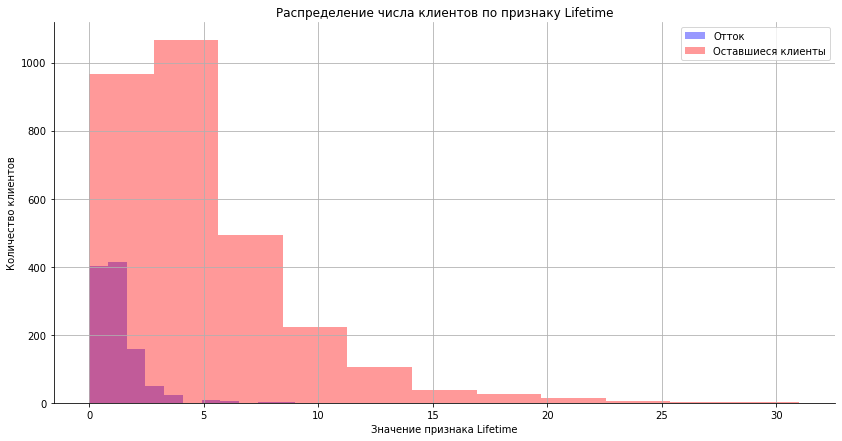

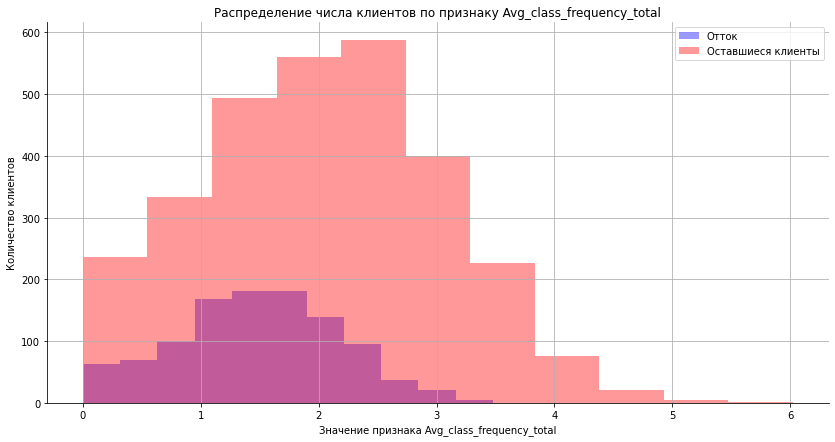

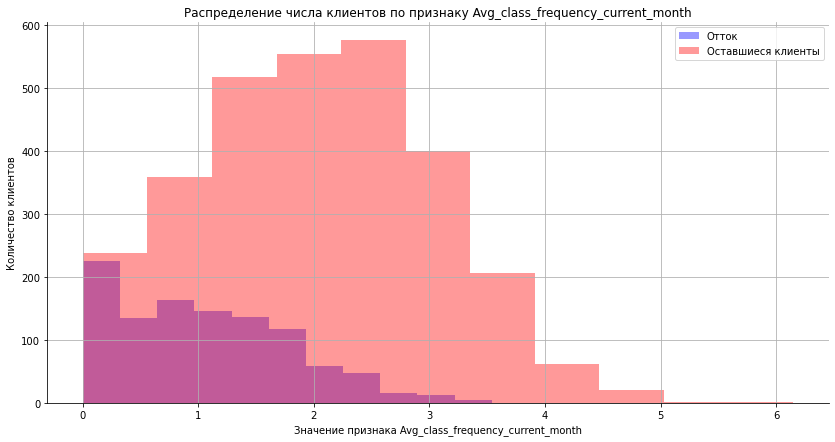

In [8]:
for col in df.drop('Churn', axis = 1).columns:
    plt.figure(figsize = (14, 7))
    plt.grid()
    
    ax = sns.distplot(df[df['Churn'] == 1][col], kde = False, label = 'Отток', color = 'blue', bins = 11)
    sns.distplot(df[df['Churn'] == 0][col], kde = False, label = 'Оставшиеся клиенты', color = 'red', ax = ax, bins = 11)
    
    plt.title('Распределение числа клиентов по признаку '+col)
    plt.xlabel('Значение признака '+col)
    plt.ylabel('Количество клиентов')
    sns.despine()
    plt.legend()
    plt.show()

Построение графиков распределения значений признаков для двух групп клиентов:

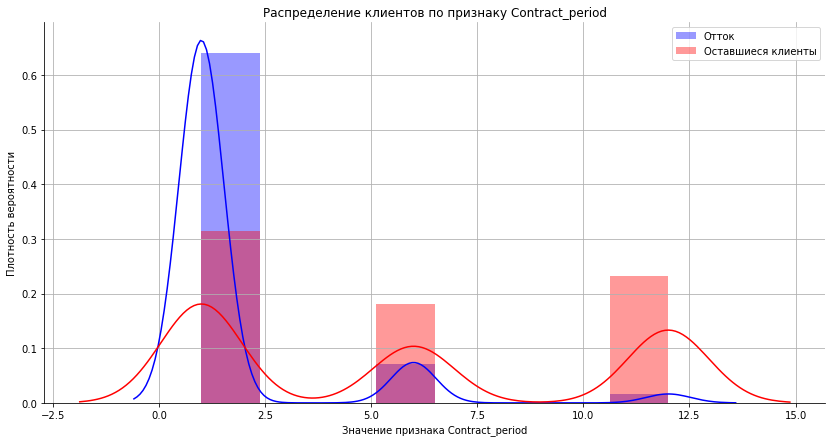

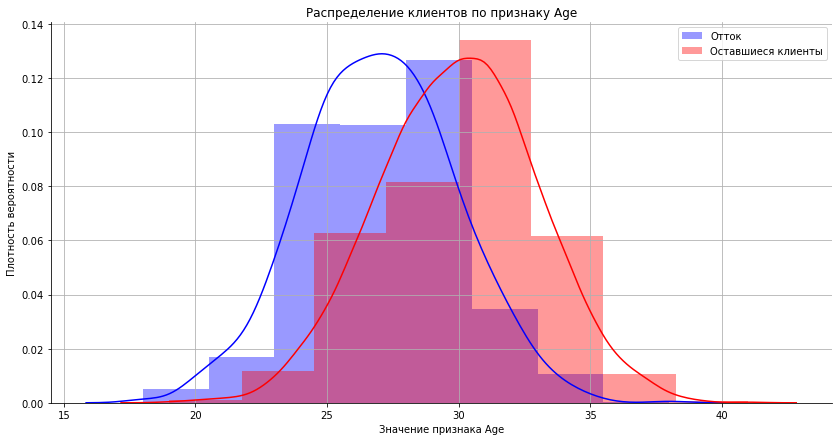

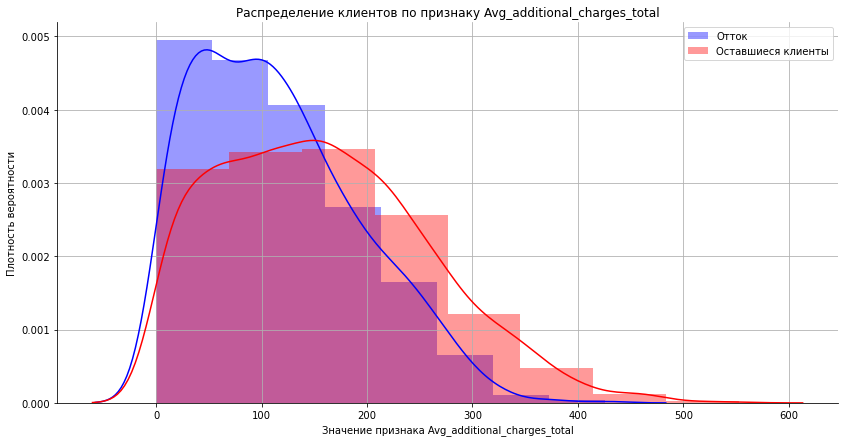

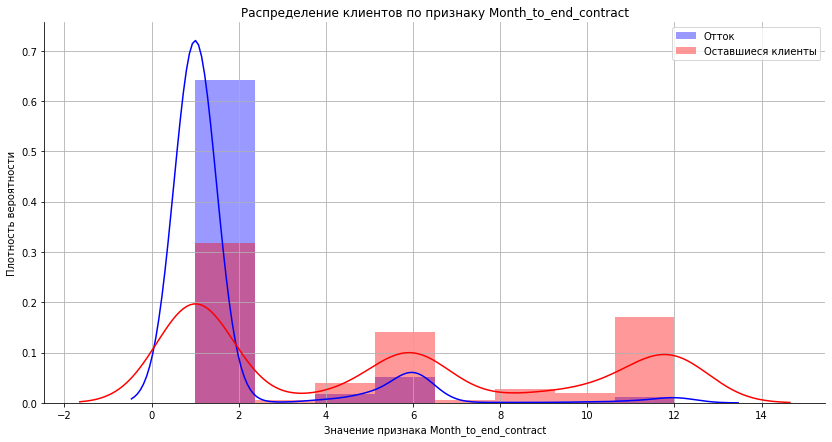

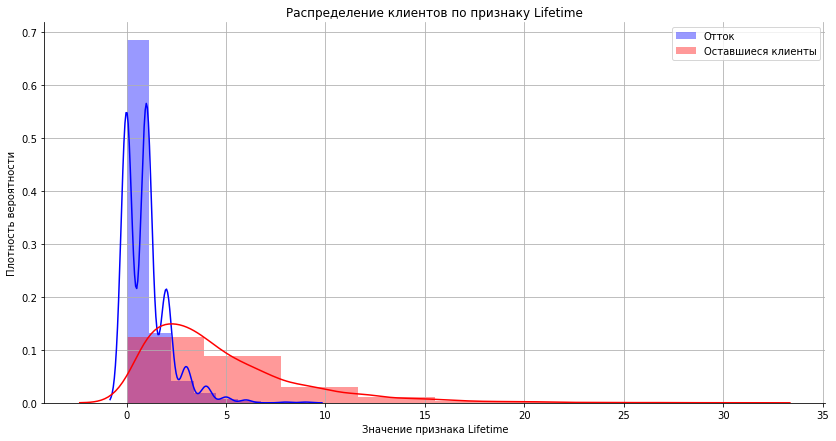

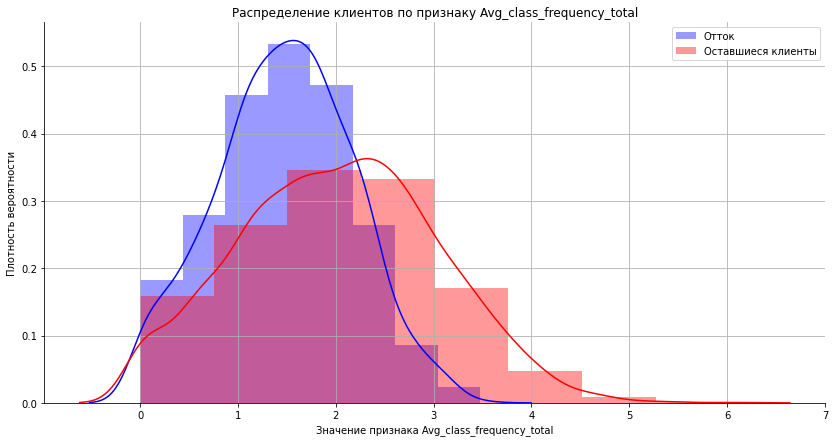

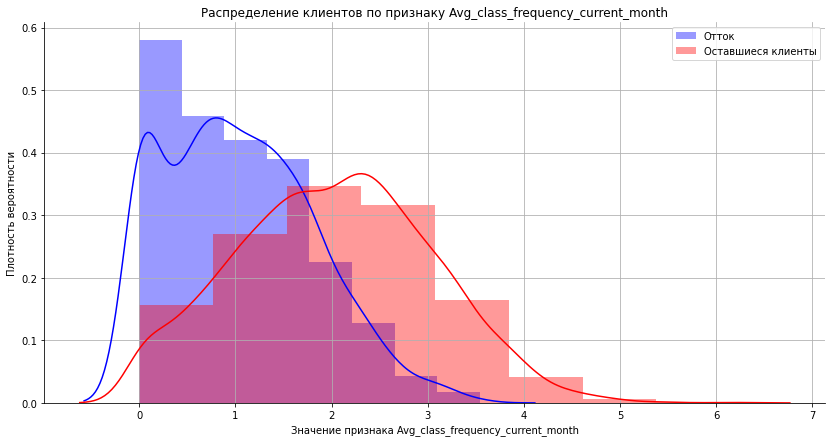

In [9]:
# используются признаки, которые нельзя отнести к типу bool
for col in ['Contract_period',
            'Age',
            'Avg_additional_charges_total',
            'Month_to_end_contract',
            'Lifetime',
            'Avg_class_frequency_total',
            'Avg_class_frequency_current_month']:
    plt.figure(figsize = (14, 7))
    plt.grid()
    
    ax = sns.distplot(df[df['Churn'] == 1][col], label = 'Отток', color = 'blue', bins = 8)
    sns.distplot(df[df['Churn'] == 0][col], label = 'Оставшиеся клиенты', color = 'red', ax = ax, bins = 8)
    
    plt.title('Распределение клиентов по признаку '+col)
    plt.xlabel('Значение признака '+col)
    plt.ylabel('Плотность вероятности')
    sns.despine()
    plt.legend()
    plt.show()

Значения Contract_period не имеют нормального распределения, т.к. существует 4 вида абонемента (на 1 месяц, на 3, на 6 и на год). Для клиентов из оттока почти все значения находятся в районе 1.

Для клиентов из оттока почти все значения Month_to_end_contract находятся в районе 1.

Кривая распределения Lifetimeдля для клиентов из оттока имеет провалы (должно было получиться распределение Пуассона).

Остальные параметры имеют кривую, похожую на распределение Пуассона.
Распределение по Age близко к нормальному.

Построение матрицы корреляций:

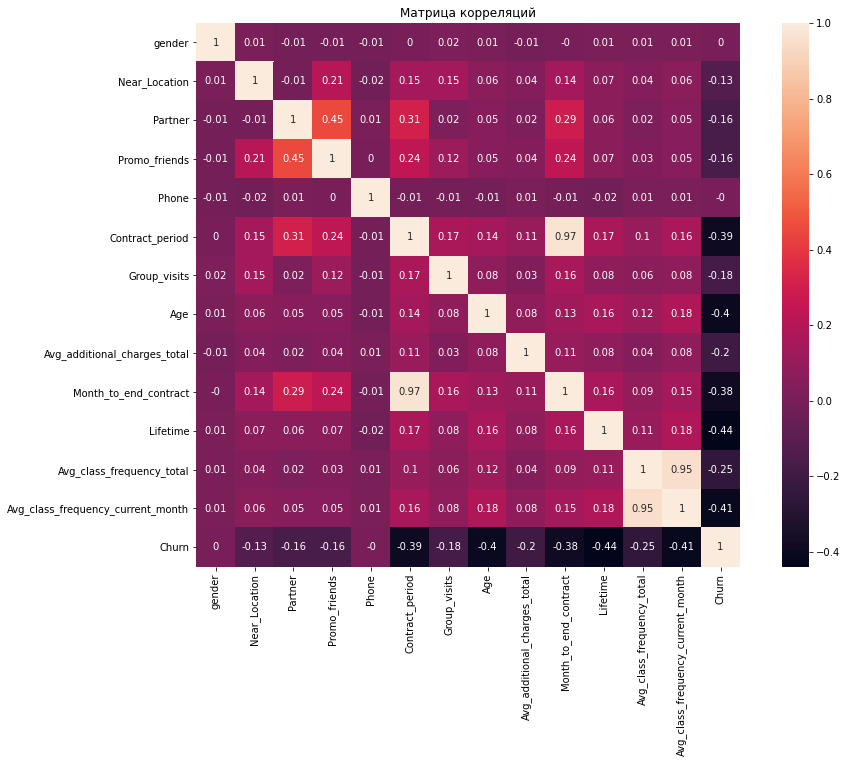

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr().round(2), annot = True, square = True)
plt.title('Матрица корреляций')
plt.show()

Из матрицы можно выделить сильные корреляции между:
 - Contract_period и Month_to_end_contract (коэффициент равен 0,97);
 - Avg_class_frequency_total и Avg_class_frequency_current_month (коэффициент равен 0,95).
 
Остальные корреляции имеют коэффициент Пирсона с модулем менее 0,8.

Выявленные связи логичны:
 - чем больше месяцев пользователь оплатил, тем больше времени у него до окончания действия абонемента;
 - средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц - это связанные параметры (чем чаще клиент посещает зал - тем они больше).
 
С оттоком сильнее всего коррелируют следующие признаки:
 - Lifetime (-0,44);
 - Avg_class_frequency_current_month (-0,41);
 - Age (-0,4);
 - Contract_period (-0,39);
 - Month_to_end_contract (-0,38).

# Промежуточный вывод к пункту 2

 - Можно предположить, что пол и наличие контактного телефона никак не влияют на отток клиентов.
 - Преде чем отправить данные алгоритму ML, нужно выполнить их стандартизацию.
 - Сильная корреляция признаков может стать причиной нерепрезентативных весов и переобученной модели. Лучше убрать такие признаки.

# 3 Построение модели прогнозирования оттока клиентов

Нужно отделить признаки X от целевой переменной y.

In [11]:
X = df.drop('Churn', axis = 1)
y = df['Churn']

Разбиение данных на обучающую и валидационную выборки:

In [12]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 0)

Второй набор признаков (без Month_to_end_contract и Avg_class_frequency_current_month):

In [13]:
X2 = df.drop(['Churn', 'Month_to_end_contract', 'Avg_class_frequency_current_month'], axis = 1)

X2_train, X2_test = train_test_split (X2, test_size = 0.2, random_state = 0)

Стандартизация данных:

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [15]:
# второй набор данных также нуждается в стандартизации
scaler2 = StandardScaler()
scaler2.fit(X2_train)
X2_train_st = scaler2.transform(X2_train)
X2_test_st = scaler2.transform(X2_test)

Будут использованы следующие алгоритмы ML:
 - логистическая регрессия;
 - случайный лес-классификатор.

In [16]:
m1_with_a_teacher = LogisticRegression()
m2_with_a_teacher = RandomForestClassifier(n_estimators = 175, random_state = 0)

Обучение и валидация моделей будут выполняться в цикле.

In [17]:
for m in [m1_with_a_teacher,
          m2_with_a_teacher]:
    m.fit(X_train_st, y_train)
    y_pred = m.predict(X_test_st)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print('Модель -', m)
    print('accuracy (доля правильных ответов) =', round(accuracy, 3),
          '\nprecision (точность) =', round(precision, 3),
          '\nrecall (полнота) =', round(recall, 3))
    print()

Модель - LogisticRegression()
accuracy (доля правильных ответов) = 0.922 
precision (точность) = 0.854 
recall (полнота) = 0.828

Модель - RandomForestClassifier(n_estimators=175, random_state=0)
accuracy (доля правильных ответов) = 0.924 
precision (точность) = 0.851 
recall (полнота) = 0.838



`n_estimators` - это число деревьев, на основании которых строится "случайный лес". При значении этого аргумента 175 модель имеет близкие к логистической регрессии метрики accuracy и precision (разница 0,2 % и 0,3 % соответственно), и чуть большую метрику recall (больше на 1 %).

Тотже цикл для второго набора данных:

In [18]:
m1_with_a_teacher2 = LogisticRegression()
m2_with_a_teacher2 = RandomForestClassifier(n_estimators = 640, random_state = 0)

for m in [m1_with_a_teacher2,
          m2_with_a_teacher2]:
    m.fit(X2_train_st, y_train)
    y_pred = m.predict(X2_test_st)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print('Модель -', m)
    print('accuracy (доля правильных ответов) =', round(accuracy, 3),
          '\nprecision (точность) =', round(precision, 3),
          '\nrecall (полнота) =', round(recall, 3))
    print()

Модель - LogisticRegression()
accuracy (доля правильных ответов) = 0.899 
precision (точность) = 0.788 
recall (полнота) = 0.808

Модель - RandomForestClassifier(n_estimators=640, random_state=0)
accuracy (доля правильных ответов) = 0.899 
precision (точность) = 0.806 
recall (полнота) = 0.778



У алгоритмов, которые обучались на полных данных, метрики лучше, чем  у обученных на данных без Month_to_end_contract и Avg_class_frequency_current_month.

Из двух алгоритмов лучшие метрики показал RandomForestClassifier (при числе деревьев 175).

Таким образом финальная модель для определения оттока клиента:

In [19]:
model_for_binary_classification = RandomForestClassifier(n_estimators = 175, random_state = 0)
model_for_binary_classification.fit(X_train_st, y_train)

RandomForestClassifier(n_estimators=175, random_state=0)

# Промежуточный вывод к пункту 3

Из рассмотренных алгоритмов лучшие результаты показал случайный лес-классификатор. Модель обучена, и её можно использовать для определения оттока клиента.

# 4 Кластеризация клиентов

Для решения задачи кластеризации алгоритму нужно передать матрицу признаков X. Данные необходимо стандартизировать.

In [20]:
X_st = scaler.fit_transform(X)

Построение дендрограммы:

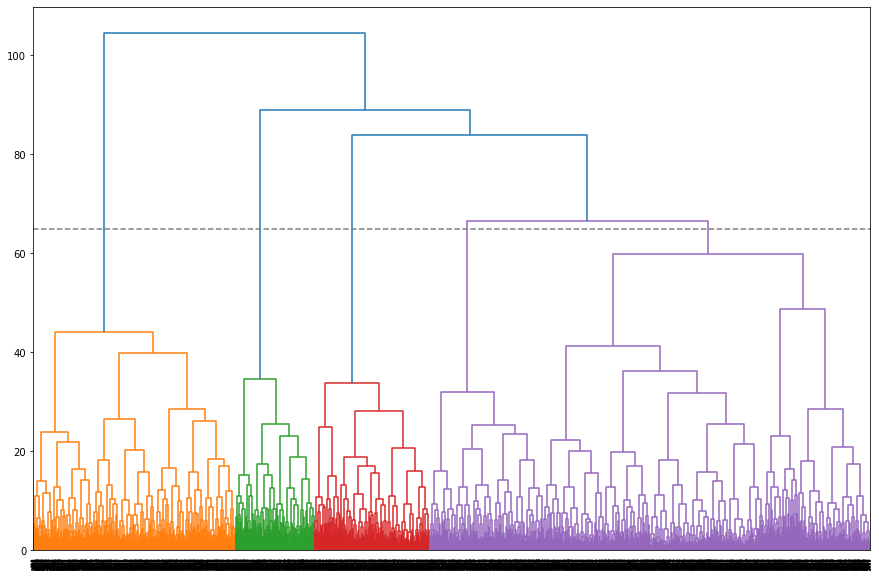

In [21]:
linked = linkage(X_st, method = 'ward')

plt.figure(figsize = (15, 10))  
dendrogram(linked, orientation = 'top')
plt.axhline(y = 65, color = 'grey', linestyle='--')
plt.show() 

По числу цветов в нижней части дендрограммы можно предположить, что кластеров 4.

Также можно отложить на вертикальной оси расстояние между кластерами, провести горизонтальную линию и узнать по числу пересечений количество кластеров.

Модель кластеризации будет обучена на основе алгоритма K-Means. Число кластеров принимается равным 5.

In [22]:
m_without_a_teacher = KMeans(n_clusters = 5, random_state = 0)

labels = m_without_a_teacher.fit_predict(X_st)

Для полученных кластеров можно вывести средние значения признаков.

In [23]:
X['cluster_KMeans'] = labels

In [24]:
X.groupby('cluster_KMeans').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
cluster_KMeans,,,,,,,,,,,,,
0,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369
1,0.480787,0.812559,0.000000,0.086223,1.000000,1.866917,0.325211,28.145267,131.369042,1.791003,2.345829,1.325865,1.086883
2,0.559567,0.858002,0.338147,0.197353,0.998797,2.730445,0.448857,30.196149,164.579011,2.519856,5.010830,2.928140,2.934140
3,0.509603,0.750320,1.000000,0.451985,1.000000,2.554417,0.303457,28.499360,129.812508,2.370038,2.832266,1.355379,1.176172
4,0.495726,0.943376,0.752137,0.541667,1.000000,11.352564,0.564103,29.993590,164.563799,10.376068,4.817308,2.028169,2.020129


Выявить какие-либо особенности по таблице затруднительно.

Столбчатые диаграммы и графики распределения должны быть более наглядными.

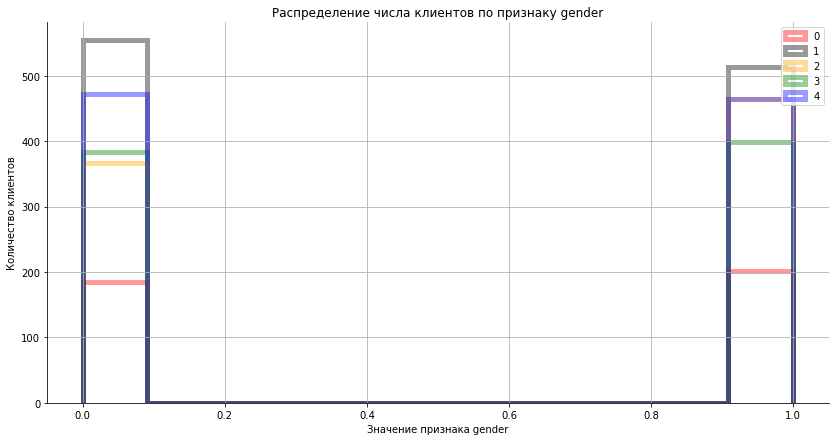

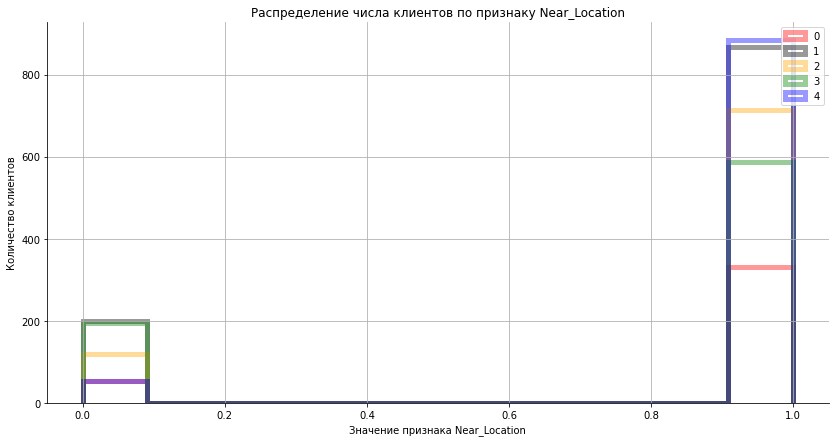

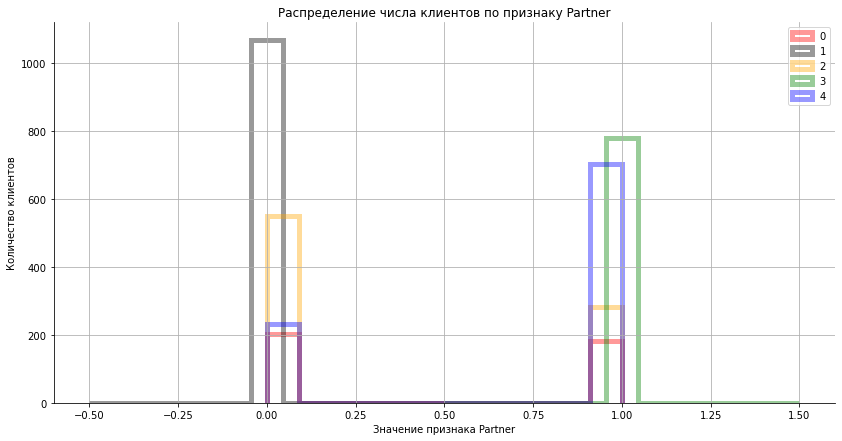

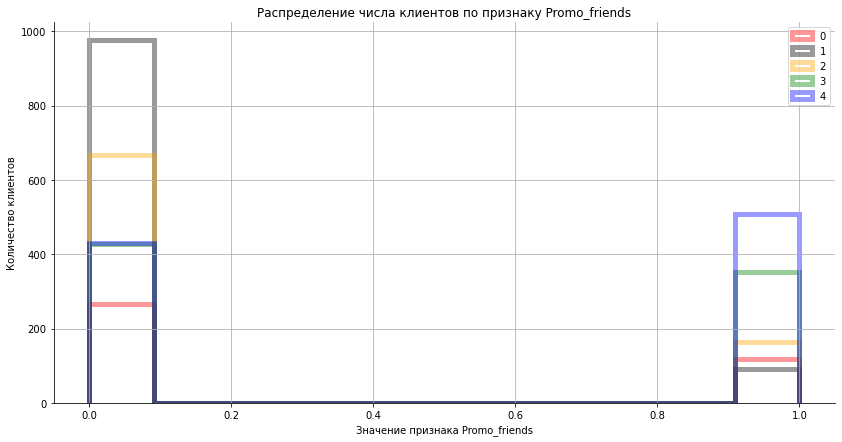

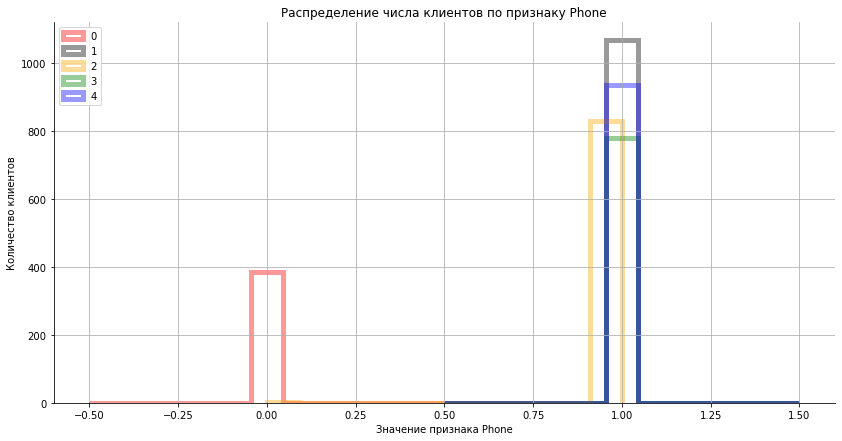

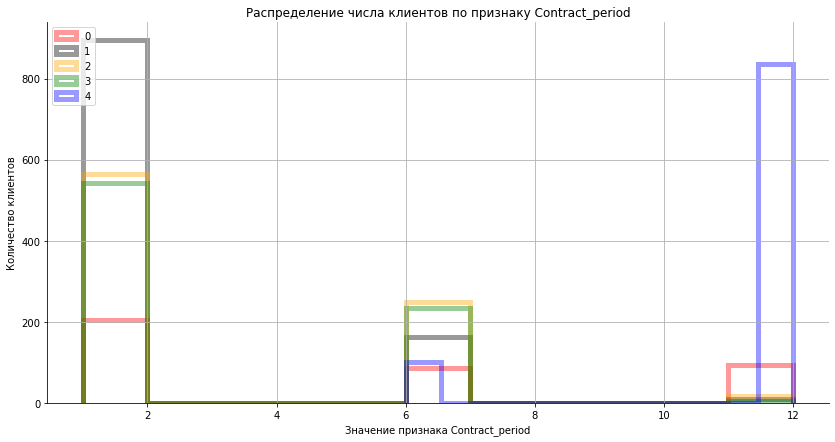

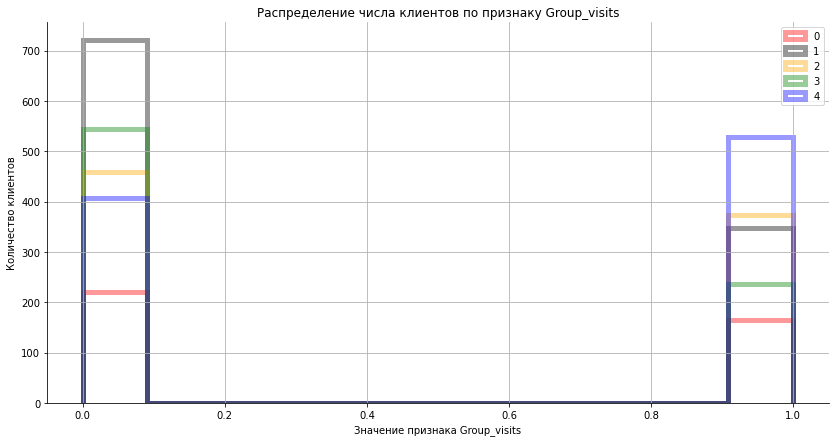

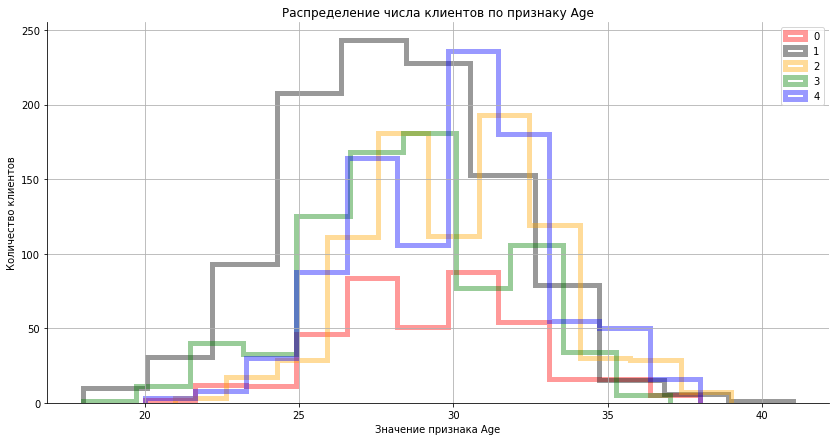

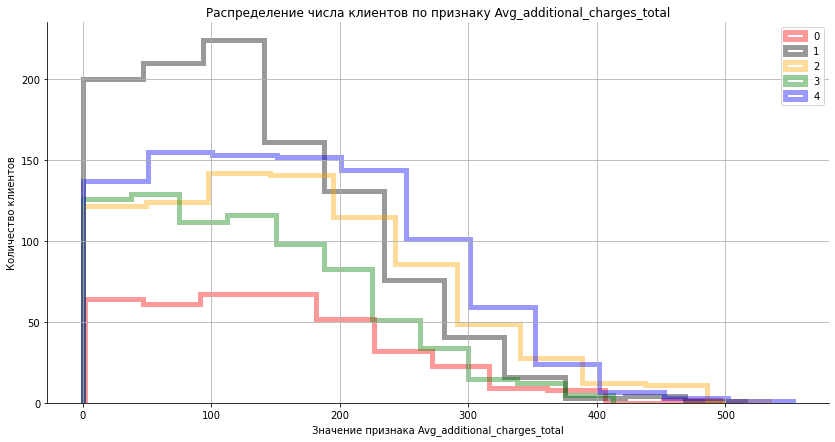

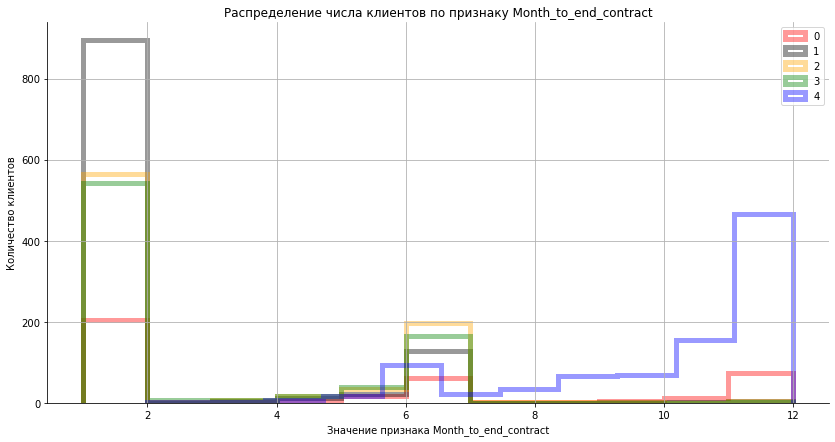

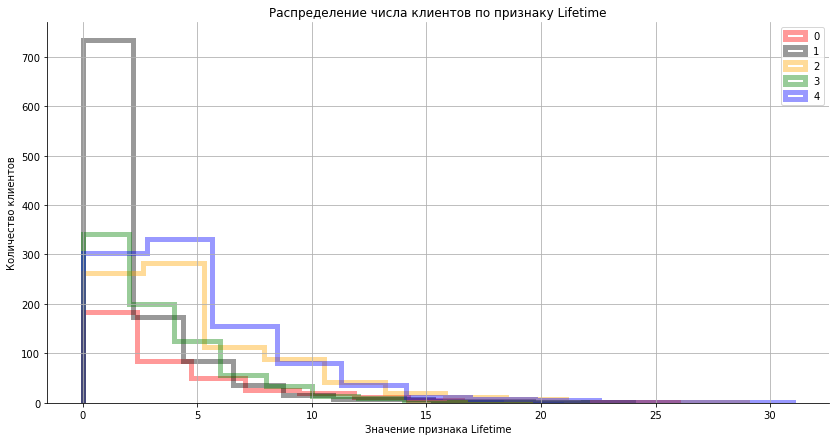

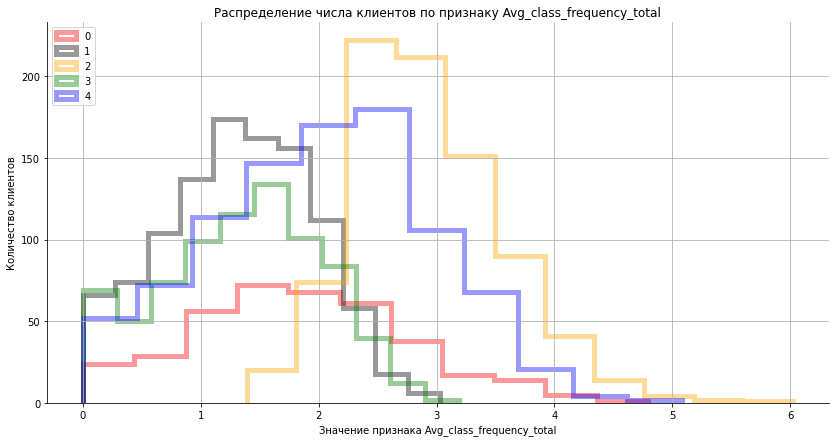

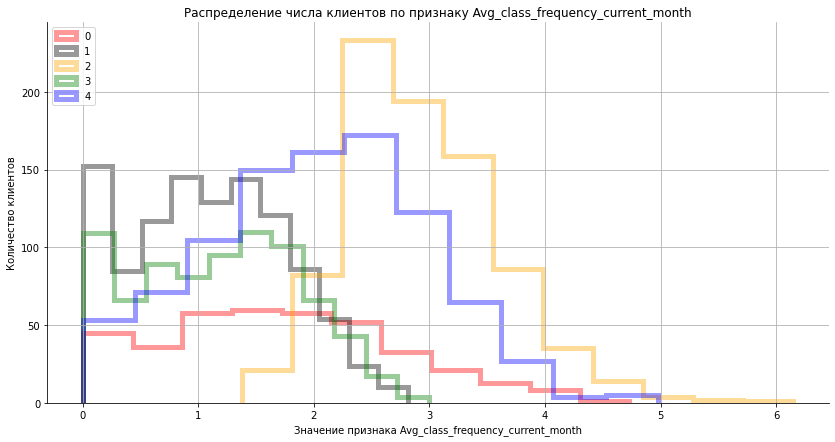

In [25]:
for col in X.drop('cluster_KMeans', axis = 1).columns:
    plt.figure(figsize = (14, 7))
    plt.grid()
    
    ax = sns.distplot(X[X['cluster_KMeans'] == 0][col], kde = False, label = '0', bins = 11, color = 'red', hist_kws={"histtype": "step", "linewidth": 5})
    bx = sns.distplot(X[X['cluster_KMeans'] == 1][col], kde = False, label = '1', ax = ax, bins = 11, color = 'black', hist_kws={"histtype": "step", "linewidth": 5})
    cx = sns.distplot(X[X['cluster_KMeans'] == 2][col], kde = False, label = '2', ax = bx, bins = 11, color = 'orange', hist_kws={"histtype": "step", "linewidth": 5})
    dx = sns.distplot(X[X['cluster_KMeans'] == 3][col], kde = False, label = '3', ax = cx, bins = 11, color = 'green', hist_kws={"histtype": "step", "linewidth": 5})
    sns.distplot(X[X['cluster_KMeans'] == 4][col], kde = False, label = '4', hist_kws={"histtype": "step", "linewidth": 5}, ax = dx, bins = 11, color = 'blue')
    
    plt.title('Распределение числа клиентов по признаку '+col)
    plt.xlabel('Значение признака '+col)
    plt.ylabel('Количество клиентов')
    sns.despine()
    plt.legend()
    plt.show()

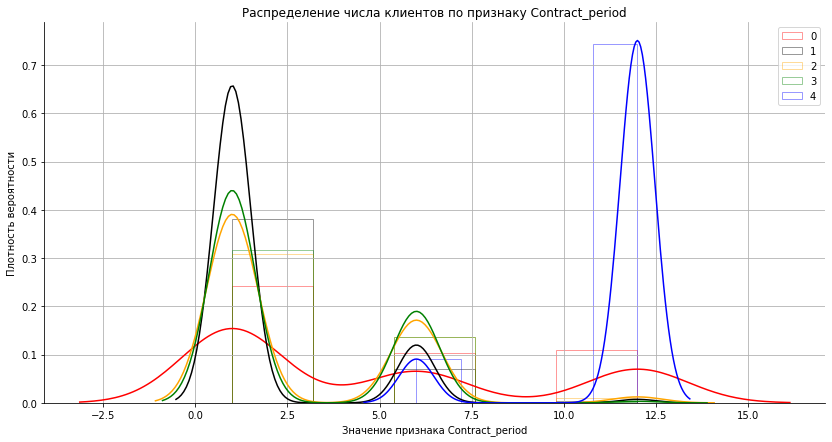

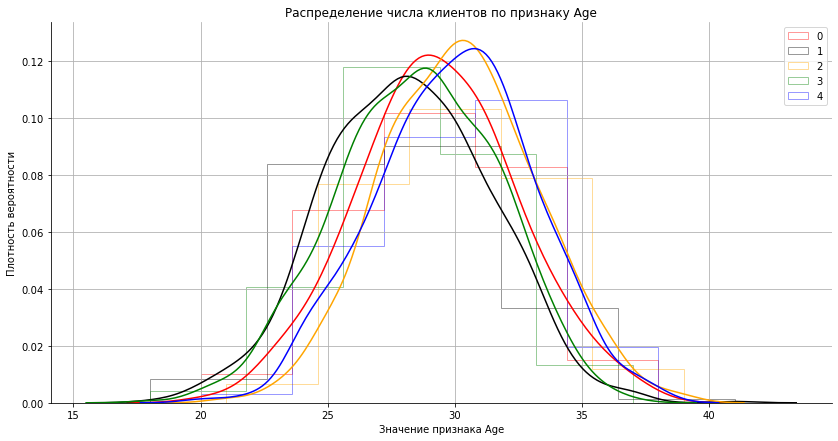

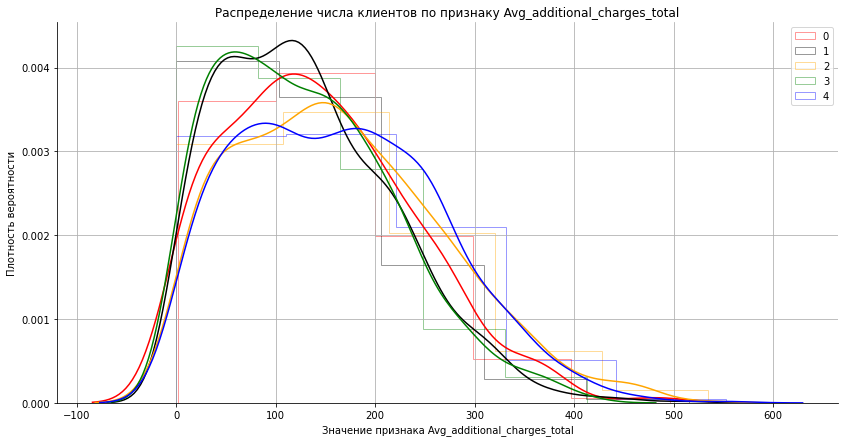

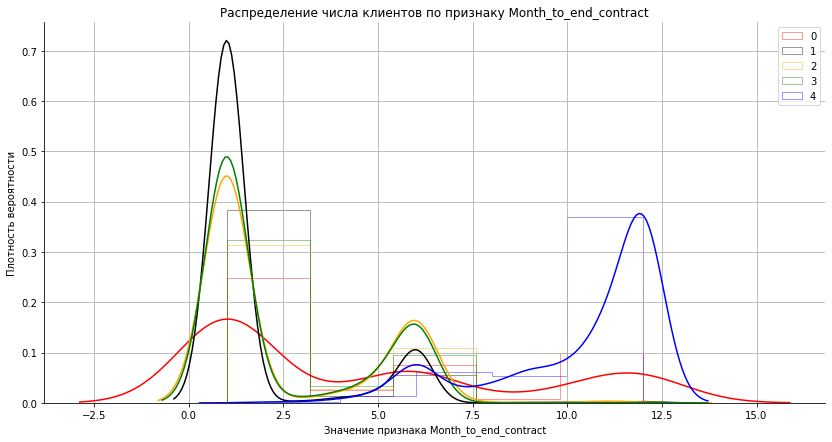

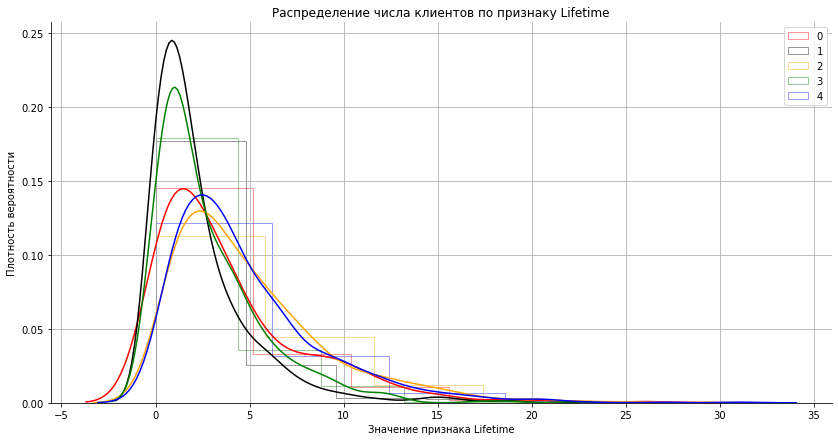

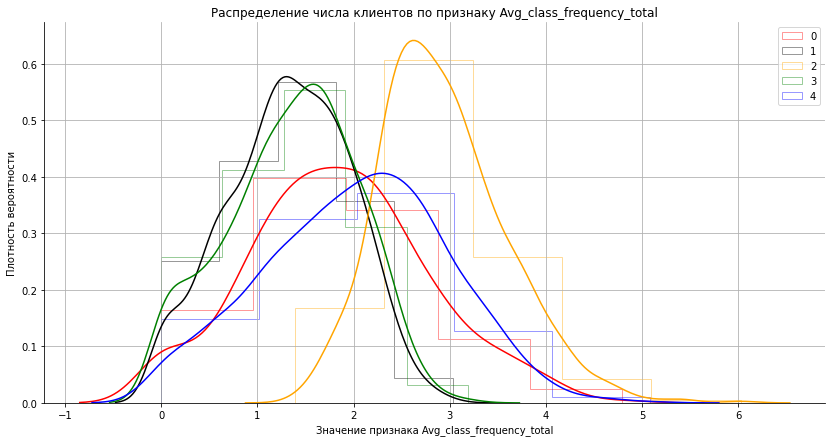

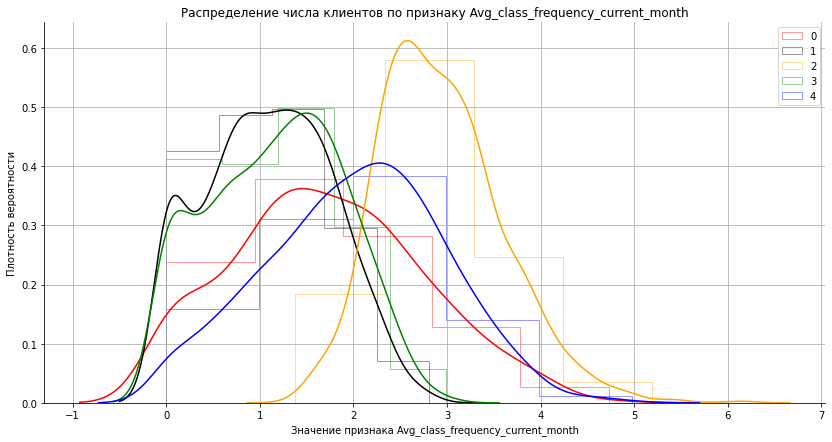

In [26]:
# используются признаки, которые нельзя отнести к типу bool
for col in ['Contract_period',
            'Age',
            'Avg_additional_charges_total',
            'Month_to_end_contract',
            'Lifetime',
            'Avg_class_frequency_total',
            'Avg_class_frequency_current_month']:
    plt.figure(figsize = (14, 7))
    plt.grid()
    
    ax = sns.distplot(X[X['cluster_KMeans'] == 0][col], kde = True, label = '0', bins = 5, color = 'red', hist_kws={"histtype": "step", "linewidth": 1})
    bx = sns.distplot(X[X['cluster_KMeans'] == 1][col], kde = True, label = '1', ax = ax, bins = 5, color = 'black', hist_kws={"histtype": "step", "linewidth": 1})
    cx = sns.distplot(X[X['cluster_KMeans'] == 2][col], kde = True, label = '2', ax = bx, bins = 5, color = 'orange', hist_kws={"histtype": "step", "linewidth": 1})
    dx = sns.distplot(X[X['cluster_KMeans'] == 3][col], kde = True, label = '3', ax = cx, bins = 5, color = 'green', hist_kws={"histtype": "step", "linewidth": 1})
    sns.distplot(X[X['cluster_KMeans'] == 4][col], kde = True, label = '4', hist_kws={"histtype": "step", "linewidth": 1}, ax = dx, bins = 5, color = 'blue')
    
    plt.title('Распределение числа клиентов по признаку '+col)
    plt.xlabel('Значение признака '+col)
    plt.ylabel('Плотность вероятности')
    sns.despine()
    plt.legend()
    plt.show()

In [27]:
df2=df
df2['cluster_KMeans'] = labels

Удалось заметить следующие особенности:

- Кластер 0:
 -  клиенты кластера 0 не указали номер телефона.

- Кластер 1:
 - клиенты кластера 1 в основном не использовали промо-код от знакомого при оплате первого абонемента;
 - у клиентов кластера 1 в основном абонемент продолжительностью 1 месяц;
 - клиенты кластера 1 в основном имеют низкие значения Lifetime.

- Кластер 2:
 - клиенты кластера 2 имеют высокие значения Avg_class_frequency_total и Avg_class_frequency_current_month.

- Кластер 3:
 - клиенты кластера 3 в основном использовали промо-код от знакомого при оплате первого абонемента.

- Кластер 4:
 - у клиентов кластера 4 в основном абонемент длительностью 1 год.

Можно рассчитать долю оттока для каждого кластера.

In [28]:
df2.groupby('cluster_KMeans').agg({'Churn':['mean', 'median']})

Churn       
                    mean median
cluster_KMeans                 
0               0.267532      0
1               0.550141      1
2               0.048135      0
3               0.395647      0
4               0.023504      0

Видно, что клиенты из кластера 1 чаще других попадают в отток.

Это клиенты:
 - которые не использовали промо-код от знакомого при оплате первого абонемента
 - у которых длительность текущего действующего абонемента 1 месяц
 - у которых момент первого обращения в фитнес-центр был совсем недавно (в течение последних 2 месяцев).

# Промежуточный вывод к пункту 4

Модель на основе алгоритма K-Means обучена, и получено 5 кластеров клиентов. Выявлен кластер, клиенты которого чаще других попадают в отток.

# 5 Выводы и базовые рекомендации по работе с клиентами

**Выводы:**
 - Построена модель прогнозирования оттока клиентов.
 - Выполнена кластеризация клиентов (получено 5 кластеров).
 - Выявлен кластер, клиенты которого чаще других попадают в отток. Для этих клиентов характерно следующее:
     - при оплате первого абонемента клиент не использовал промо-код;
     - длительность текущего действующего абонемента клиента составляет 1 месяц;
     - первое обращение в фитнес-центр было в течение последних 2 месяцев.
     
**Рекомендации:**
 - увеличить число промо-кодов, которые клиент может раздать своим знакомым;
 - убрать абонемент длительностью 1 месяц (можно ввести 1 бесплатное "пробное" посещение для потенциального клиента);
 - делать СМС-рассылку клиентам, которые 21-28 дней не посещали фитнес-центр.